## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help in OH if you're stuck.

### Reminder

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), or use all the available data. 


In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (61.7 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import random
from sklearn.model_selection import train_test_split
%tensorflow_version 2.x
import tensorflow as tf
from matplotlib.colors import Normalize

TensorFlow 2.x selected.


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

def apply_mask(im, mask, color=(1,0,0)):
    masked = np.zeros(im.shape)
    for x,y in mask: masked[x][y] = color
    return masked

In [0]:
def plot_image(image,mask):
  fig, axes = plt.subplots(1,2, figsize=(15,15), dpi=100)
  axes[0].imshow(image)
  
  axes[1].imshow(image)
  axes[1].imshow(mask, cmap='jet', alpha=0.3)

In [0]:
def get_path(train_img_list):
  tumor_path = []
  tumor_mask_path =[]
  for i in range(len(train_img_list)):
    a = '/content/drive/My Drive/myslide/Copy of tumor_'+train_img_list[i]+'.tif'
    b = '/content/drive/My Drive/myslide/Copy of tumor_'+train_img_list[i]+'_mask.tif'
    tumor_path.append(a)
    tumor_mask_path.append(b)
  return tumor_path, tumor_mask_path

In [0]:
def get_sample(slide, mask, levelnum):
  patchsize = 299
  # patch_tissue = []
  slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=levelnum, 
                         width=slide.level_dimensions[levelnum][0], 
                         height=slide.level_dimensions[levelnum][1])
  mask_image = read_slide(mask, 
                         x=0, 
                         y=0, 
                         level=levelnum, 
                         width=slide.level_dimensions[levelnum][0], 
                         height=slide.level_dimensions[levelnum][1])[:,:,0]
  tissue_bad = np.nonzero(mask_image)
  # print(len(tissue_bad[0]))                      
  tissue_pixels = list(find_tissue_pixels(slide_image))
  tissue_regions = apply_mask(slide_image, tissue_pixels)
  tissue_all = np.nonzero(tissue_regions[:,:,0])
  tissue_health = np.nonzero(tissue_regions[:,:,0]-mask_image)
  sample_bad = random.sample(list(zip(tissue_bad[1], tissue_bad[0])),100)
  sample_good = random.sample(list(zip(tissue_health[1], tissue_health[0])),100)
  sample = sample_bad+sample_good
  return sample
# coordinate


In [0]:
def get_trainset(sample, slide, mask, levelnum):
  patch_tissue = []
  maskimage = []
  lable = []
  patchsize = 299
  centersize = 128
  df = pow(2,levelnum)
  for i in range(len(sample)):
 
    (x,y) = sample[i]
    corrdinate_x = x-patchsize//2
    corrdinate_y = y-patchsize//2
    center_x = x-centersize//2
    center_y = y-centersize//2
    region = read_slide(slide, x=corrdinate_x * df, y= corrdinate_y * df, level=levelnum, width=299, height=299)
    mask_center = read_slide(mask, x=center_x * df, y= center_y * df, level=levelnum, width=128, height=128)
    mask_region = read_slide(mask, x=corrdinate_x * df, y= corrdinate_y * df, level=levelnum, width=299, height=299)
    if mask_center.any():
      lable.append(1)
    else: lable.append(0)
    tissue_pixels = list(find_tissue_pixels(region))
    tissue_regions = apply_mask(region, tissue_pixels)
    patch_tissue.append(tissue_regions)
    maskimage.append(mask_region)
  return patch_tissue, lable, maskimage

In [0]:
#level5 dataset
train_img_list = ['016', '084', '101', '110', '064']
test_img_list = ['091']
train_tumor_path, train_tumor_mask_path = get_path(train_img_list)
test_tumor_path, test_tumor_mask_path = get_path(test_img_list)
training_image_lev5=[]
training_lable = []
training_image_lev4=[]
training_lable_lev4 = []
mask_lev5 = []
mask_lev4 = []
for i in range(len(train_tumor_path)):
  slide_i = open_slide(train_tumor_path[i])
  mask_i = open_slide(train_tumor_mask_path[i])
  sample_data_1 = get_sample(slide_i, mask_i, 5)
  sample_data_2 = get_sample(slide_i, mask_i, 4)
  patch_image_1, lable_1, m1 = get_trainset(sample_data_1, slide_i, mask_i, 5)
  patch_image_2, lable_2, m2 = get_trainset(sample_data_2, slide_i, mask_i, 4)
  training_image_lev5.extend(patch_image_1)
  training_lable.extend(lable_1)
  training_image_lev4.extend(patch_image_2)
  # mask_lev5.extend(m1)
  # mask_lev4.extend(m2)
  # training_lable_lev4.extend(lable_2)
  

In [0]:
test_img_list = ['091']
test_tumor_path = '/content/drive/My Drive/myslide/Copy of tumor_'+test_img_list[0]+'.tif'
test_tumor_mask_path = '/content/drive/My Drive/myslide/Copy of tumor_'+test_img_list[0]+'_mask.tif'
test_slide = open_slide(test_tumor_path)
test_mask = open_slide(test_tumor_mask_path)
test_sample_5 = get_sample(test_slide, test_mask, 5)
test_sample_4 = get_sample(test_slide, test_mask, 4)
test_image_lev5, test_lable, testm_5 = get_trainset(test_sample_5, test_slide, test_mask, 5)
test_image_lev4, test_lable, testm_4 = get_trainset(test_sample_4, test_slide, test_mask, 4)

In [0]:
print(len(test_lable))

200


In [0]:
X1_trainval_filename = 'multi'+'_X1_trainval.npy'
X2_trainval_filename = 'multi'+'_X2_trainval.npy'
y_trainval_filename = 'multi'+'_y_trainval.npy'

np.save(X1_trainval_filename, training_image_lev5)
np.save(X2_trainval_filename, training_image_lev4)
np.save(y_trainval_filename, training_lable)



In [0]:
X1_test_filename = 'multi'+'_X1_test.npy'
X2_test_filename = 'multi'+'_X2_test.npy'
y_test_filename = 'multi'+'_y_test.npy'

np.save(X1_test_filename, test_image_lev5)
np.save(X2_test_filename, test_image_lev4)
np.save(y_test_filename, test_lable)

In [0]:
training_image_lev5 = np.load('/content/drive/My Drive/multi_X1_trainval.npy')
training_image_lev4 = np.load('/content/drive/My Drive/multi_X2_trainval.npy')
training_lable = np.load('/content/drive/My Drive/multi_y_trainval.npy')
# test_image_lev5 = 

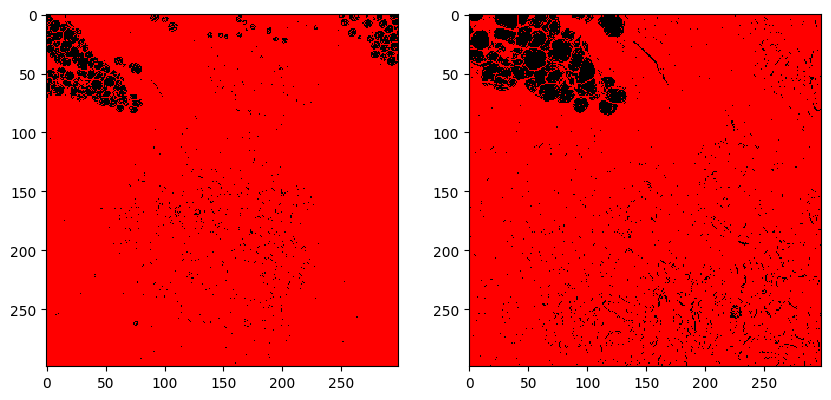

In [6]:
fig, axes = plt.subplots(1,2, figsize=(10,10), dpi=100)
axes[0].imshow(training_image_lev5[200])
axes[1].imshow(training_image_lev4[200])
# axes[1].imshow(mask, cmap='jet', alpha=0.3)

In [7]:
training_image_lev5 = np.asarray(training_image_lev5)
training_image_lev4 = np.asarray(training_image_lev4)
training_lable = np.asarray(training_lable)

# training_image_lev4 = np.asarray(training_lable_lev4)
X1_train, X1_val, y_train, y_val = train_test_split(training_image_lev5, training_lable, test_size=0.2, 
                                 random_state=42, stratify=training_lable, shuffle=True)

X2_train, X2_val, y_train, y_val = train_test_split(training_image_lev4, training_lable, test_size=0.2, 
                                random_state=42, stratify=training_lable, shuffle=True)
print(len(X2_train),len(X2_val))

800 200


In [0]:
del training_image_lev5, training_lable, training_image_lev4

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def multi_generate(X1,X2,y):
    
  while True:
      # shuffle indices    
      idx = np.random.permutation(X1.shape[0])
      # create image generator
      datagen = ImageDataGenerator()

      # get batches with the defied indices
      batches = datagen.flow(X1[idx], y[idx], batch_size=32)
      idx0 = 0
      for batch in batches:
          idx1 = idx0 + batch[0].shape[0]

          # yield batch with input2 with the same indexes as input 1 and target
          yield [batch[0], X2[idx[idx0:idx1]]], batch[1]

          idx0 = idx1
          if idx1 >= X1.shape[0]:
              break

In [0]:
train_ds = multi_generate(X1_train/255.0, X2_train/255.0, y_train)
val_ds = multi_generate(X1_val/255.0, X2_val/255.0, y_val)

model

In [0]:
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model, Sequential

image_input_1 = Input(shape=(299,299,3)) 
image_input_2 = Input(shape=(299,299,3)) 


model_level_1 = Sequential()
model_level_1.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
model_level_1.add(BatchNormalization())
model_level_1.add(Activation('relu'))
model_level_1.add(MaxPooling2D(pool_size=(2, 2)))
model_level_1.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model_level_1.add(BatchNormalization())
model_level_1.add(Activation('relu'))
model_level_1.add(MaxPooling2D(pool_size=(2, 2)))
# model_level_1.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
# model_level_1.add(BatchNormalization())
# model_level_1.add(Activation('relu'))
# model_level_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1_output = model_level_1(image_input_1) 

model_level_2 = Sequential()
model_level_2.add(Conv2D(32, kernel_size=(3, 3), padding='same'))
model_level_2.add(BatchNormalization())
model_level_2.add(Activation('relu'))
model_level_2.add(MaxPooling2D(pool_size=(2, 2)))
model_level_2.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model_level_2.add(BatchNormalization())
model_level_2.add(Activation('relu'))
model_level_2.add(MaxPooling2D(pool_size=(2, 2)))
# model_level_2.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
# model_level_2.add(BatchNormalization())
# model_level_2.add(Activation('relu'))
# model_level_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2_output = model_level_2(image_input_2) 


merged = tf.keras.layers.concatenate([model_1_output, model_2_output])
output = Flatten()(merged)
output = Dense(256, activation='relu')(output)
output = Dense(1, activation='sigmoid')(output)

#final model
model = Model(inputs=[image_input_1, image_input_2], outputs=output)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 74, 74, 64)   19776       input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 74, 74, 64)   19776       input_2[0][0]                    
______________________________________________________________________________________________

In [18]:
from tensorflow.keras import datasets, layers, models,optimizers

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(train_ds,
                    steps_per_epoch=800//32,
                    epochs=5,
                    
                    )

  ...
    to  
  ['...']
Train for 25 steps
Epoch 1/5
25/25 [==============================] - 5s 198ms/step - loss: 0.3002 - accuracy: 0.9100
Epoch 2/5
25/25 [==============================] - 4s 154ms/step - loss: 0.1722 - accuracy: 0.9438
Epoch 3/5
25/25 [==============================] - 4s 154ms/step - loss: 0.1705 - accuracy: 0.9362
Epoch 4/5
25/25 [==============================] - 4s 155ms/step - loss: 0.1383 - accuracy: 0.9625
Epoch 5/5
25/25 [==============================] - 4s 152ms/step - loss: 0.1499 - accuracy: 0.9488


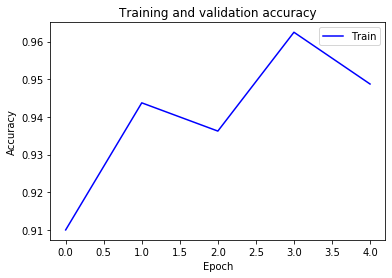

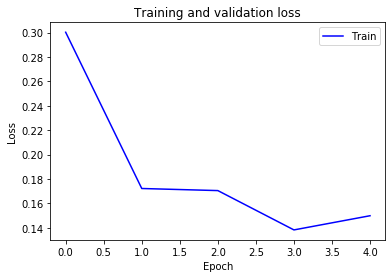

In [19]:
acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
loss = history.history['loss']
# val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, color='blue', label='Train')
# plt.plot(epochs, val_acc, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, color='blue', label='Train')
# plt.plot(epochs, val_loss, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [0]:
# delet unnecessary information
del train_ds, val_ds

heat map

In [0]:
def check_cancer(x,y,mask,levelnum):
  centersize = 128
  df = pow(2,levelnum)
  center_x = x-centersize//2
  center_y = y-centersize//2
  mask_center = read_slide(mask, x=center_x * df, y= center_y * df, level=levelnum, width=128, height=128)
  if mask_center.any():
    a = 1     
  else: a = 0
  return a

In [0]:
def get_prepatch(x,y,slide,levelnum):
  df = pow(2,levelnum)
  patchsize = 299
  corrdinate_x = x-patchsize//2
  corrdinate_y = y-patchsize//2
  region = read_slide(slide, x=corrdinate_x * df, y= corrdinate_y * df, level=levelnum, width=299, height=299)
  tissue_pixels = list(find_tissue_pixels(region))
  tissue_regions = apply_mask(region, tissue_pixels)

  return tissue_regions

In [29]:
pre = []
truelable = []
testlist_5 = []
testlist_4 = []
heat_x = []
heat_y = []

test_img_list = ['101']
test_tumor_path = '/content/drive/My Drive/myslide/Copy of tumor_'+test_img_list[0]+'.tif'
test_tumor_mask_path = '/content/drive/My Drive/myslide/Copy of tumor_'+test_img_list[0]+'_mask.tif'
test_slide = open_slide(test_tumor_path)
test_mask = open_slide(test_tumor_mask_path)
slide_test = read_slide(test_slide, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width=test_slide.level_dimensions[7][0], 
                        height=test_slide.level_dimensions[7][1])
mask_test = read_slide(test_mask, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width=test_mask.level_dimensions[7][0], 
                        height=test_mask.level_dimensions[7][1])[:,:,0]
                        
tissue_pixels = list(find_tissue_pixels(slide_test))
tissue_regions = apply_mask(slide_test, tissue_pixels)
# plt.figure(figsize=(10,10), dpi=100)
# plt.imshow(tissue_regions)
# print(tissue_regions[:,:,0])
heatmap = np.zeros((test_slide.level_dimensions[7][1],test_slide.level_dimensions[7][0]))
count = 0
for x in range(100,test_slide.level_dimensions[7][1]-80,10):
  for y in range(120,test_slide.level_dimensions[7][0]-80,10):
    
    if tissue_regions[x,y,0] == 1 and count<2000:
        x5 = x*pow(2,2)
        y5 = y*pow(2,2)  #level 7 to level 5
        x4 = x*pow(2,3)
        y4 = y*pow(2,3)  #level 7 to level 4
        test_patch_5 = get_prepatch(y5, x5, test_slide, 5)
        test_patch_4 = get_prepatch(y4, x4, test_slide, 4)
        testlist_5.append(test_patch_5)
        testlist_4.append(test_patch_4)
        heat_x.append(x)
        heat_y.append(y)
        true = check_cancer(y5, x5, test_mask, 5)
        truelable.append(true)
        count += 1
testlist_5 = np.asarray(testlist_5)/255.0
testlist_4 = np.asarray(testlist_4)/255.0
predict = model.predict([testlist_5,testlist_4])
print(min(predict))




[0.04607048]


In [0]:
heatmap = np.zeros((test_slide.level_dimensions[7][1],test_slide.level_dimensions[7][0]))
error = 0
for i in range(1,len(predict)):
  if predict[i]>0.95:
    heatmap[heat_x[i]-5:heat_x[i]+5,heat_y[i]-5:heat_y[i]+5] = 1
  # if 0.8<predict[i]<0.999:
  #   heatmap[heat_x[i]-5:heat_x[i]+5,heat_y[i]-5:heat_y[i]+5] = 0.2

    error += abs(truelable[i]-predict[i])


In [40]:
accurary = 1-error/len(predict)
print(accurary)

[0.8336729]


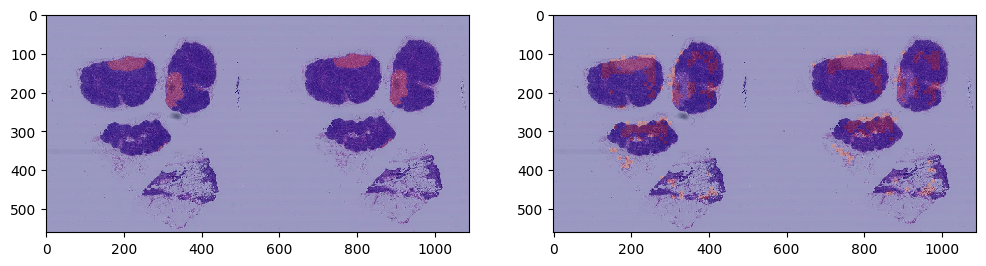

In [39]:
#draw heatmap
fig, axes = plt.subplots(1,2, figsize=(12,12), dpi=100)
axes[0].imshow(slide_test)
axes[0].imshow(mask_test, cmap='jet', alpha=0.3)
axes[1].imshow(slide_test)
axes[1].imshow(heatmap, cmap='jet', alpha=0.3)

In [0]:
del predict, test_slide, test_mask, testlist